# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias, Q. Bertrand, N. Gazagnadou

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated proximal gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 6th of october at 21:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 30 septembre 2019**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [22]:
# Change here using YOUR first and last names
fn1 = "manon"
ln1 = "rivoire"
fn2 = "alexis"
ln2 = "gerbeaux"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_rivoire_manon_and_gerbeaux_alexis.ipynb


In [0]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Generating sparse coefficients

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

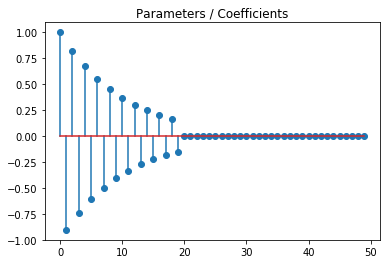

In [25]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [0]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [0]:
A, b = simu_linreg(coefs);
# print("A : \n", A)
# print("b : \n", b)
# A, b = simu_logreg(coefs);  # uncomment when you want to test logistic regression
# print("A : \n", A)
# print("b : \n", b)

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{\lambda\,R}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization: $\lambda\, R(z) = \frac{\lambda}{2} \|z\|_2^2$
- L1 penalization: $\lambda\, R(z) = \lambda\|z|\|_1$

where $\lambda \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $\lambda \, R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
     <li>Hint: for the prox of the L1 norm you can either use the formula from the course or rewrite it with np.max and np.sign functions
    </li>
      <li>Visualize the identity function and the proximity operators of the L2 and L1 on the real axis
    </li>
    </ul>
</div>

In [0]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    z = np.sign(x)*np.maximum(np.abs(x)-lmbd,0)
    return z

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd*np.linalg.norm(x,1)

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    z = x/(lmbd + 1)
    return z

def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return (lmbd/2)*np.linalg.norm(x,2)**2

prox L1 : 
 [-4 -3 -2 -1  0  0  0  1  2  3]
L1 penalization : 
 25.0
prox L2 : 
 [-2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2. ]
L2 penalization : 
 42.5


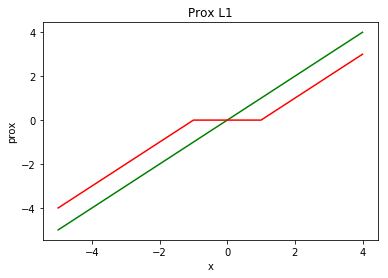

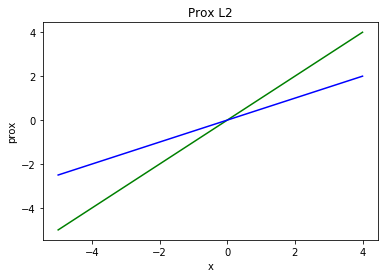

In [30]:
# Plots TODO
x = np.arange(-5,5)
lmbd = 1
print("prox L1 : \n", prox_L1(x,lmbd))
print("L1 penalization : \n", L1_norm(x,lmbd))
print("prox L2 : \n", prox_L2(x,lmbd))
print("L2 penalization : \n", L2_norm(x,lmbd))

plt.title("Prox L1") 
plt.xlabel("x") 
plt.ylabel("prox") 
plt.plot(x,x,'g')
plt.plot(x,prox_L1(x,lmbd), 'r')
plt.show()
plt.title("Prox L2")
plt.xlabel("x")
plt.ylabel("prox")
plt.plot(x,x,'g')
plt.plot(x, prox_L2(x,lmbd), 'b')
plt.show()


## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

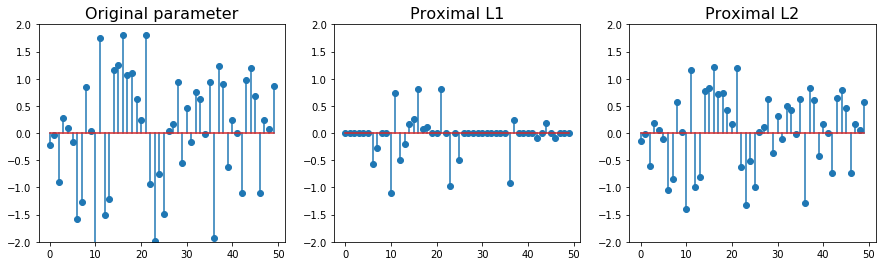

In [31]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

## Comments 

Let's remember the objective : we would like to model the relationship linking the output variable y to the 50 features in such a way that the term errors (or loss) between the ground truth labels and the predicted output values might be minimized. <br/>
In order to determine the optimal parameters of the model we have to minimize the cost function J while finding a trade-off between overfitting and underfitting. <br/>
In order to reach this aim we add a regularization term to the cost function J which in our case is either the Lasso regularization (L1 norm) or the Ridge regularization (L2 norm). <br/>

### Lasso Regularization (L1)

We can realize thanks to the plots above, that the Lasso Regularization enables to obtain a sparse vector of weights. Indeed, the proximal operator is defined as follows : $sign(x)(|x| - \lambda)_{+}$, therefore, in the case where the parameter x is lower than the regularization parameter $\lambda$, then the given parameter x is updated to 0, whereas when the parameter x is greater than the regularization parameter $\lambda$, then the given parameter is just shrinked by removing $\lambda$ from it. This creates sparsity in the vector of weights. <br/>

### Ridge Regularization (L2)

The Ridge Regularization allows to obtain a scaled vector of weights. Indeed, the proximal operator is defined as follows : $\frac{x}{1+s}$, therefore, the parameters x are shrinked by multiplying them by the factor $\frac{1}{1+s}$ what creates a scaled down vector of weights.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ is prox friendly.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A^\top = [a_1,\ldots, a_n] \in \mathbb{R}^{d \times n}$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient $\nabla f$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these loss functions are correct by numerically checking their ouputs</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [0]:
n = A.shape[0]
def loss_linreg(x):
    """Least squares loss"""
    loss = (1/(2*n))*np.linalg.norm(b-np.dot(A,x),2)**2
    return loss

def grad_linreg(x):
    """Least squares gradient"""
    grad = -(1/n)*np.dot(np.transpose(A),b-np.dot(A,x))
    return grad

def loss_logreg(x):
    """Logistic loss"""
    loss = (1/n)*sum(np.log(1+np.exp(-b*np.dot(A,x))))
    return loss

def grad_logreg(x):
    """Logistic gradient"""
    v = b*1/(1+np.exp(b*np.dot(A,x)))
    grad = -(1/n)*np.dot(np.transpose(A),v)
    
    return grad

# TO BE COMPLETED

In [34]:
from scipy.optimize import check_grad
x =randn(50)

A, b = simu_linreg(coefs)
A, b = simu_logreg(coefs)
# loss_linreg(x)
# grad_linreg(x)
# print(loss_linreg(x))
# print(grad_linreg(x))
# loss_logreg(x)
# grad_logreg(x)
# print(grad_logreg(x))
# print(loss_logreg(x))

check_grad(loss_linreg, grad_linreg, x)
check_grad(loss_logreg, grad_logreg, x)

2.5071457808536916e-06

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_{\lambda R}$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the Lipschitz constant for linear and logistic regression losses. Remark: for the logistic regression, you should try to upper bound the second derivative</li>
      <li>Hint: the computation of the Lipschitz constant for the linear regression should be easy (cf course).
         But the computation of the Lipschitz constant for the logistic regression may be trickier. 
                 You may want to write $f$ as $f(x) = \frac{1}{n} \sum_i \phi(b_i a_i^\top x)$, and then show that $|\phi''| \leq \frac{1}{4}$.</li>
      <li>Implement functions that compute the Lipschitz constant for both cases (linear and logistic regression). Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (Be careful with the norm you chose! Read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD (Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms.
       Note: PGD is sometimes called ISTA (Iterative Soft Thresholding Algorithm) and APGD is sometimes called FISTA (Fast ISTA)</li> 
    </ul>
</div>

In [0]:
# TO BE COMPLETED

# Calculate the smoothness constant for least squares loss
def smoothness_const_linreg(A):
    """Lipschitz constant for least squares loss"""    
    L = (1/n)*(np.linalg.norm(A, ord=2))**2
    return L
  
# Calculate the smoothness constant for logistic loss    
def smoothness_const_logreg(A):
    """Lipschitz constant for logistic loss"""    
    L = (1/(4*n))*(np.linalg.norm(A, ord=2))**2
    return L
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Launching PGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_R(x - step*grad_f(x), lmbd)
        x = x_new
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [0]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Launching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new = prox_R(z - step*grad_f(z), lmbd)
        t_new = (1+ np.sqrt(1+4*t**2))/2
        z = (x_new + ((t-1)/t_new)*(x_new-x))
        t = t_new
        x = x_new
        
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [0]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the problem (linear regression or logistic regression) using the parameters given above. This can be done by using APGD with 1000 iterations and setting `x_true` to `coeffs`.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer you have computed. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

### Minimum and Minimizer for the Linear Regression using PGD with 1000 iterations 

In [0]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)
# print("Minimization via PGD or ISTA : \n")
x_min, obj_min, err_min = PGD(x0=x0, f=loss_linreg, grad_f=grad_linreg, R=L2_norm, prox_R=prox_L2, step=1/L, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)
# print("Minimum : \n", obj_min[-1])
# print("Minimizers : \n", x_min)

### Minimum and Minimizer for the Linear Regression using APGD with 1000 iterations

In [0]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)
x_min, obj_min, err_min = APGD(x0=x0, f=loss_linreg, grad_f=grad_linreg, R=L2_norm, prox_R=prox_L2, step=1/L, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)

# print("Minimization via APGD or FISTA :\n")
# print("Minimum : \n", obj_min[-1])
# print("Minimizers : \n", x_min)

### Comparison of the convergences of PGD and APGD in terms of distance to the minimum and distance to the minimizer

In [0]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)

x_min_PGD, obj_min_PGD, err_min_PGD = PGD(x0=x0, f=loss_linreg, grad_f=grad_linreg, R=L2_norm, prox_R=prox_L2, step=1/L, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)
x_min_APGD, obj_min_APGD, err_min_APGD = APGD(x0=x0, f=loss_linreg, grad_f=grad_linreg, R=L2_norm, prox_R=prox_L2, step=1/L, lmbd=lmbd, n_iter=n_iter,
         x_true=coefs, verbose=True)

# Plot of the minimizer with PGD and APGD Methods in function of the number of iterations
# Convergence happens very fast: plotting the last iterations of the algorithm is not very 
# explanatory as the error stops decreasing past the 100th step
n_max = 1000
plt.figure(figsize=(16, 5))
plt.plot(range(n_max), err_min_PGD[:n_max], 'b-', label="PGD or ISTA")
plt.plot(range(n_max), err_min_APGD[:n_max], 'r-', label="APGD or FISTA")
plt.legend()
plt.xlabel("Step")
plt.ylabel("$log(error)$")
plt.title("Distance to the minimizer with PGD APGD Methods throughout iteration steps")
plt.yscale('log')
plt.show()

# Plot for the objective function of the minimizer ( the minimum)
n_max = 50
plt.figure(figsize=(16, 5))
# plt.plot(range(n_max), np.log(np.abs(obj_ista[:n_max] - obj_ista[-1])), 'b-', label="ISTA")
# plt.plot(range(n_max), np.log(np.abs(obj_fista[:n_max] - obj_fista[-1])), 'r-', label="FISTA")
plt.plot(range(n_max), np.abs(obj_min_PGD[:n_max]), 'b-', label="PGD or ISTA")
plt.plot(range(n_max), np.abs(obj_min_APGD[:n_max]), 'r-', label="APGD or FISTA")
plt.legend()
plt.xlabel("Step")
plt.ylabel("$log(error)$")
plt.title("Distance to the minimum with PGD and APGD Methods throughout iteration steps")
plt.yscale("log")
plt.show()



<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of L2 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for L2 and L1 penalizations. Explain</li>
    </ul>
</div>

### Comparison of the solution obtained with ista and fista with the true parameter 'coefs' of the model

Text(0.5, 1.0, 'Parameters / Coefficients')

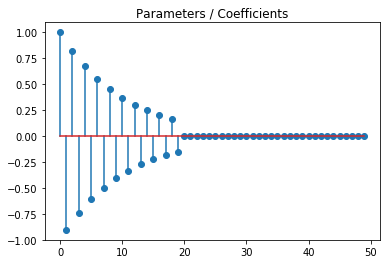

In [63]:
plt.stemn_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Influence of the correlation of the features on the performance of the optimization algorithms in the Linear And Logistic Regressions frameworks

